# KINTSUGI: Knowledge Integration with New Technologies for Simplified User-Guided Image processing

### In the following notebook you will prepare for processing your images; test illumination correction parameters, stitching accuracy, and deconvolution.

## 1. Import packages. 
### *This must be done every time the notebook is started or restarted.

Run cells using Ctrl+Enter or by pressing the play (triangle) button.

In [1]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import gc
import os as os
from tqdm.notebook import tqdm
import cupy as cp
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog
import pandas as pd
from Kstitch.stitching import stitch_images
from glob import glob
from skimage.io.collection import alphanumeric_key
import shutil
import numpy as np
from skimage.io import imread 
from skimage.io import imsave
from skimage import io
from skimage import util
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
import pickle
from itertools import chain, repeat
import subprocess
from datetime import datetime
import imagej, scyjava
import logging
from typing import List
from skimage.transform import resize as skresize
from scipy.fftpack import dct, idct
current_dateTime = datetime.now()

## 2. Define directory paths.  
### *This must be done every time the notebook is started or restarted.

If you are familiar with defining directories, enter them below.  If not the other cells will assist with the necessary definitions. Once you have established the directories with Method B, use Method A by copying the directories in their respective variable names.

Below are two ways to get the required paths to input, output (stich_dir for corrected, stitched images), and meta folders.  The first is where they can be entered manually.  The second assists with the process.  

Choose only one method: A or B

### 2.1 Method A

In [2]:
base_dir = "C:/Users/smith6jt/KINTSUGI"
image_dir ="C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_raw"
stitch_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_BaSiC_Stitched"
meta_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_meta"

print(f"Base folder is {base_dir}.")
print(f"Image folder is {image_dir}.")
print(f"Stitching folder is {stitch_dir}.")
print(f"Meta folder is {meta_dir}.")

Base folder is C:/Users/smith6jt/KINTSUGI.
Image folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_raw.
Stitching folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_BaSiC_Stitched.
Meta folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_meta.


### 2.2 Method B

First, assess the folder and file names.  For example, in CODEX output, the original folder name is something like CX_20-008_SP_CC2-B. We can shorten that now to make life easier down the road.  Shorten the folder name to remove redundant information.  In this example we choose "2008_CC2B_raw" making sure the '_raw' is the last part.

Running the following cell will bring up a dialog window where you will enter the new folder name and select the folder containing your images.  Make sure there are only a series of folders each containing the images for each cycle in the folder you select.  This folder will be renamed and designated as "image_dir" for the project.  A stitching output folder and a folder for metadata files will also be created.  

In [ ]:
root = tk.Tk()
root.withdraw()

user_choice = simpledialog.askstring("Shortened name", "Enter shortened file name with _raw at end")
image_dir_long = filedialog.askdirectory()
head_dir, tail_dir = os.path.split(image_dir_long)
base_dir, _ = os.path.split(head_dir)

try:  
    os.rename(image_dir_long, os.path.join(head_dir, user_choice))
except FileNotFoundError:
    print("The file or directory does not exist.")
except PermissionError:
    print("you don't have permissions to rename the file")
except OSError as error:
    print(f"Error: {error}")

if os.path.isdir(os.path.join(head_dir, user_choice)) == True:
    image_dir = os.path.join(head_dir, user_choice)
    print(f"{image_dir_long} renamed to {image_dir}")

else:
    print("Error in renaming.")
    
stitch_dir = image_dir.replace('_raw', '_BaSiC_Stitched')
meta_dir = image_dir.replace('_raw', '_meta')
os.makedirs(stitch_dir, exist_ok=True)
os.makedirs(meta_dir, exist_ok=True)

if os.path.isdir(stitch_dir) == True:
    print(f"Stitching output folder: {stitch_dir} created successfully.")

else:
    print("Stitching output folder not created.")

if os.path.isdir(meta_dir) == True:
    print(f"Metadata folder: {meta_dir} created successfully.  Move metadata files to metadata folder.")

else:
    print("Metadata folder not created.")

### 2.3 Shorten cycle folder names

NOTE: Running this cell permanently alters the cycle folder names.  This only needs to be run once.

If the cycle folders have long names starting with the cycle numbers followed by a split character (e.g. the underscore in 'cyc001_reg001_200210_170925') this cell will shorten the folder name to everything before the first split character.

Make sure to run the codeblock above before moving on to the next code block.

Enter the split character in quotations.  It is usually an underscore.

Note that the rest of the folder name will be deleted unless you add additional arguments to the os.rename function.

In [ ]:
# Rename long source folder names

split_character = simpledialog.askstring("Split character", "Enter split character")
print(f'Split character is {split_character}.')
if split_character == 'None':
    print('No input given.')

else:
    for cyc_folder in os.listdir(image_dir):
        new_name = cyc_folder.split(split_character)
        cycle_dir = os.path.join(image_dir, cyc_folder)
        cycle_dir_short = os.path.join(image_dir, new_name[0])
        os.rename(cycle_dir, cycle_dir_short)
        if os.path.isdir(cycle_dir_short) == True:
            print(f"{cycle_dir} renamed to {cycle_dir_short}")

Before running very large image datasets, first inspect a sample of images, and then check the quality of illumination correction, stitching, and deconvolution.  Here parameters can be tested, tuned, and refined as necessary with visual inspection of a single cycle, zplane, channel combination.  Starting with the nuclear staining channel or other channels necessary for segmentation is a good idea, then make sure to assess channels with differing staining patterns and intensities.

Make sure the directories are defined!

The zplane and channel numbers of interest, and the pattern of the image_file name must be entered below.  The wildcard characters "??" are entered where the image tile numbers are so that all tiles are loaded.

The cycle folder names are assumed to have been shortened and in the format "cyc00x".  Running the cell will prompt to enter the cycle folder of interest or you may comment out the first line and uncomment the second where your folder is defined.
    

### 2.4 Import test set

In [4]:
# cycle_folder = filedialog.askdirectory()
cycle_folder = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_raw/cyc001"

zplane = 8 
channel = 2

# image_file name below is derived from 1_000tt_Z0zz_CHc.tif where tt is the tile number with one leading zero, zz is the z-position with one leading zero, and c is the channel number.
image_file = f'1_000??_Z0{str(zplane).zfill(2)}_CH{channel}.tif'
print(f"Using {cycle_folder}/{image_file}")

#Convert to numpy array
im_raw = sorted(glob(os.path.join(cycle_folder, image_file)), key = alphanumeric_key)
im = io.imread_collection(im_raw)
im_array_init = np.asarray(im)
print(f"Image shape is {im_array_init.shape} and type is {im_array_init.dtype}\nMin value is {im_array_init.min()} and max value is {im_array_init.max()}")

Using C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_raw/cyc001/1_000??_Z008_CH2.tif
Image shape is (63, 1440, 1920) and type is uint16
Min value is 0 and max value is 4855


## 3. Illumination Correction

Define the function to resize the images to a smaller and square dimension for estimating the uneven illumination.  Usually no changes need to be made here.

In [4]:
RESIZE_ORDER = 1
RESIZE_MODE = "symmetric"
PRESERVE_RANGE = True
OUTPUT_IMAGE = "OutputImage"

def _resize_images_list(images_list: List, side_size: float = None, x_side_size: float = None, y_side_size: float = None):
    if side_size is not None:
        y_side_size = x_side_size = side_size
    resized_images_list = []
    for i, im in enumerate(images_list):
        if im.shape[0] != x_side_size or im.shape[1] != y_side_size:
            resized_images_list.append(skresize(
                im, 
                (x_side_size, y_side_size), 
                order = RESIZE_ORDER, 
                mode = RESIZE_MODE,
                preserve_range = PRESERVE_RANGE
                )
            )
        else:
            resized_images_list.append(im)
    return resized_images_list

Run the resize function and prints out some information about the images.  Usually no changes need to be made here.

In [5]:
_saved_size = im[0].shape
working_size = 128
nrows = ncols = working_size

downsized_image = np.dstack(_resize_images_list(images_list=im, side_size=working_size))
print(f"Downsized image shape is {downsized_image.shape} and type is {downsized_image.dtype}\nMin value is {downsized_image.min()} and max value is {downsized_image.max()}")

Downsized image shape is (128, 128, 63) and type is float64
Min value is 100.11630717478822 and max value is 2771.1888579166134


Plot the original image and histogram next to the resized image and histogram.  Enter a number for "i" that is within the range of the number of images in your dataset for one channel.  For this and the rest of the image/histogram cells, you can adjust the size of the plot by entering values for "figsize."  You can also change the colors of the images by changing "cmap."

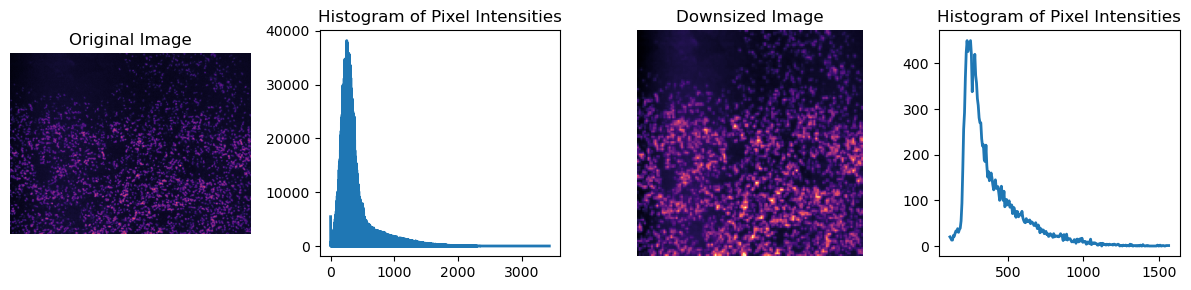

In [6]:
i = 40

hist, hist_centers = exposure.histogram(im_array_init[i])
hist2, hist_centers2 = exposure.histogram(downsized_image[:,:,i])
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(im_array_init[i], cmap='magma')
axes[0].set_title('Original Image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(downsized_image[:,:,i], cmap='magma')
axes[2].set_title('Downsized Image')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

This cell takes the average of all the image tiles and standardizes.

In [7]:
mean_image = np.mean(downsized_image, axis=2)
mean_div = mean_image/np.mean(mean_image)

View the mean and standardized images as above.

In [ ]:
i = 40

hist, hist_centers = exposure.histogram(mean_image)
hist2, hist_centers2 = exposure.histogram(mean_div)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(mean_image, cmap='magma')
axes[0].set_title('Downsized image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(mean_div, cmap='magma')
axes[2].set_title('Mean of downsized images')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

This cell defines the function to to calculate a compressed representation of the image data and the next cells runs the function and allow for visualization as before.  Usually no changes need to be made here.

In [8]:
def _dct2d(mtrx: np.array):
    """
    Calculates 2D discrete cosine transform.
    
    Parameters
    ----------
    mtrx
        Input matrix.  
        
    Returns
    -------    
    Discrete cosine transform of the input matrix.
    """
     
    # Check if input object is 2D.
    if mtrx.ndim != 2:
        raise ValueError("Passed object should be a matrix or a numpy array with dimension of two.")

    return dct(dct(mtrx.T, norm='ortho').T, norm='ortho')

In [9]:
Dis_Cos_Trans_mean = _dct2d(mean_div.T)

In [ ]:
hist, hist_centers = exposure.histogram(mean_div)
hist2, hist_centers2 = exposure.histogram(Dis_Cos_Trans_mean)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(mean_div, cmap='magma')
axes[0].set_title('Mean Image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(Dis_Cos_Trans_mean, cmap='magma', vmin=-0.1, vmax=0.3)
axes[2].set_title('Discrete Cosine \nTransform of Mean Image')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

This cell defines functions to inverse the dct function, estimate the illumination correction, and resize the images to their original shape.  Usually no changes need to be made here.

In [10]:
def _idct2d(mtrx: np.array):
    """
    Calculates 2D inverse discrete cosine transform.
    
    Parameters
    ----------
    mtrx
        Input matrix.  
        
    Returns
    -------    
    Inverse of discrete cosine transform of the input matrix.
    """
     
    # Check if input object is 2D.
    if mtrx.ndim != 2:
        raise ValueError("Passed object should be a matrix or a numpy array with dimension of two.")
 
    return idct(idct(mtrx.T, norm='ortho').T, norm='ortho')

def _shrinkageOperator(matrix, epsilon):
    temp1 = matrix - epsilon
    temp1[temp1 < 0] = 0
    temp2 = matrix + epsilon
    temp2[temp2 > 0] = 0
    res = temp1 + temp2
    return res

def _inexact_alm_rspca_l1(
    images, 
    lambda_flatfield, 
    if_darkfield, 
    lambda_darkfield, 
    optimization_tolerance, 
    max_iterations,
    weight=None, 
    ):

    if weight is not None and weight.size != images.size:
            raise IOError('weight matrix has different size than input sequence')

    # Shape variables
    p = images.shape[0]           # Image height
    q = images.shape[1]           # Image width
    m = p*q                       # Total pixels per image
    n = images.shape[2]          # Number of images
    images = np.reshape(images, (m, n), order='F')

    if weight is not None:
        weight = np.reshape(weight, (m, n), order='F')
    else:
        weight = np.ones_like(images)

    # SVD and Norm variables    
    _, svd, _ = np.linalg.svd(images, full_matrices=False) # SVD decomposition
    norm_two = svd[0] # Largest singular value
    d_norm = np.linalg.norm(images, ord='fro') # Frobenius norm of images

    # Optimization parameters
    dual_var_lowrank = 0 # Dual variable for low-rank component (Y1)
    lagrange_mult1 = 1 # Lagrange multiplier for first constraint (ent1)
    lagrange_mult2 = 10 # Lagrange multiplier for second constraint (ent2)
    penalty_factor = 12.5 / norm_two # (mu)
    penalty_factor_bar = penalty_factor * 1e7 # Upper bound for penalty (mu_bar)
    scale_ratio = 1.5 # Scale factor for penalty updates

    # Component matrices
    A1_hat = np.zeros_like(images) # Estimated flat-field
    A1_coeff = np.ones((1, images.shape[1])) # Flat-field coefficients
    E1_hat = np.zeros_like(images) # Estimated error/noise
    W_hat = _dct2d(np.zeros((p, q)).T) # DCT coefficients

    # Offset and mask variables
    A_offset = np.zeros((m, 1)) # Offset for flatfield
    B1_uplimit = np.min(images) # Upper limit for darkfield
    B1_offset = 0 # Darkfield offset
    A_inmask = np.zeros((p, q)) # Inner mask for optimization
    # Mask covers central region (5/6 x 5/6)
    A_inmask[int(np.round(p / 6) - 1): int(np.round(p*5 / 6)), int(np.round(q / 6) - 1): int(np.round(q * 5 / 6))] = 1

    # main iteration loop starts
    iter = 0
    total_svd = 0
    converged = False

    while not converged:
 
        iter += 1

        if len(A1_coeff.shape) == 1:
            A1_coeff = np.expand_dims(A1_coeff, 0)
        if len(A_offset.shape) == 1:
            A_offset = np.expand_dims(A_offset, 1)

        W_idct_hat = _idct2d(W_hat.T)
        A1_hat = np.dot(np.reshape(W_idct_hat, (-1,1), order='F'), A1_coeff) + A_offset

        temp_W = (images - A1_hat - E1_hat + (1 / penalty_factor) * dual_var_lowrank) / lagrange_mult1
        temp_W = np.reshape(temp_W, (p, q, n), order='F')
        temp_W = np.mean(temp_W, axis=2)

        W_hat = W_hat + _dct2d(temp_W.T)
        W_hat = np.maximum(W_hat - lambda_flatfield / (lagrange_mult1 * penalty_factor), 0) + np.minimum(W_hat + lambda_flatfield / (lagrange_mult1 * penalty_factor), 0)
        W_idct_hat = _idct2d(W_hat.T)

        if len(A1_coeff.shape) == 1:
            A1_coeff = np.expand_dims(A1_coeff, 0)
        if len(A_offset.shape) == 1:
            A_offset = np.expand_dims(A_offset, 1)

        A1_hat = np.dot(np.reshape(W_idct_hat, (-1,1), order='F'), A1_coeff) + A_offset
        E1_hat = images - A1_hat + (1 / penalty_factor) * dual_var_lowrank / lagrange_mult1
        E1_hat = _shrinkageOperator(E1_hat, weight / (lagrange_mult1 * penalty_factor))
        R1 = images - E1_hat
        A1_coeff = np.mean(R1, 0) / np.mean(R1)
        A1_coeff[A1_coeff < 0] = 0

        if if_darkfield:
            validA1coeff_idx = np.where(A1_coeff < 1)

            B1_coeff = (np.mean(R1[np.reshape(W_idct_hat, -1, order='F') > np.mean(W_idct_hat) - 1e-6][:, validA1coeff_idx[0]], 0) - \
            np.mean(R1[np.reshape(W_idct_hat, -1, order='F') < np.mean(W_idct_hat) + 1e-6][:, validA1coeff_idx[0]], 0)) / np.mean(R1)
            k = np.array(validA1coeff_idx).shape[1]
            temp1 = np.sum(A1_coeff[validA1coeff_idx[0]]**2)
            temp2 = np.sum(A1_coeff[validA1coeff_idx[0]])
            temp3 = np.sum(B1_coeff)
            temp4 = np.sum(A1_coeff[validA1coeff_idx[0]] * B1_coeff)
            temp5 = temp2 * temp3 - temp4 * k
            if temp5 == 0:
                B1_offset = 0
            else:
                B1_offset = (temp1 * temp3 - temp2 * temp4) / temp5

            B1_offset = np.maximum(B1_offset, 0)
            B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))
            B_offset = B1_offset * np.reshape(W_idct_hat, -1, order='F') * (-1)
            B_offset = B_offset + np.ones_like(B_offset) * B1_offset * np.mean(W_idct_hat)

            A1_offset = np.mean(R1[:, validA1coeff_idx[0]], axis=1) - np.mean(A1_coeff[validA1coeff_idx[0]]) * np.reshape(W_idct_hat, -1, order='F')
            A1_offset = A1_offset - np.mean(A1_offset)
            A_offset = A1_offset - np.mean(A1_offset) - B_offset

            # smooth A_offset
            W_offset = _dct2d(np.reshape(A_offset, (p,q), order='F').T)
            W_offset = np.maximum(W_offset - lambda_darkfield / (lagrange_mult2 * penalty_factor), 0) + \
                np.minimum(W_offset + lambda_darkfield / (lagrange_mult2 * penalty_factor), 0)
            A_offset = _idct2d(W_offset.T)
            A_offset = np.reshape(A_offset, -1, order='F')

            # encourage sparse A_offset
            A_offset = np.maximum(A_offset - lambda_darkfield / (lagrange_mult2 * penalty_factor), 0) + \
                np.minimum(A_offset + lambda_darkfield / (lagrange_mult2 * penalty_factor), 0)
            A_offset = A_offset + B_offset


        Z1 = images - A1_hat - E1_hat # Constraint violation
        dual_var_lowrank = dual_var_lowrank + penalty_factor * Z1 # Dual variable updates
        penalty_factor = np.minimum(penalty_factor * scale_ratio, penalty_factor_bar)
        
        # Stop Criterion
        stopCriterion = np.linalg.norm(Z1, ord='fro') / d_norm
        print(f'Iteration {iter}, stopCriterion: {stopCriterion}')
        if stopCriterion < optimization_tolerance:
            converged = True

        if not converged and iter >= max_iterations:
            converged = True
    A_offset = np.squeeze(A_offset)
    A_offset = A_offset + B1_offset * np.reshape(W_idct_hat, -1, order='F')
    return A1_hat, E1_hat, A_offset

def _resize_image(image: np.ndarray, side_size: float  = None, x_side_size: float = None, y_side_size: float = None):
    if side_size is not None:
        y_side_size = x_side_size = side_size
    if image.shape[0] != x_side_size or image.shape[1] != y_side_size:
        return skresize(
            image,
            (x_side_size, y_side_size), 
            order = RESIZE_ORDER, 
            mode = RESIZE_MODE,
            preserve_range = PRESERVE_RANGE
        )
    else:
        return image

The following cell runs the illumination correction estimation and returns two models.  It is based on the Basic correction algorithm implemented by the Peng lab https://github.com/peng-lab as a Cellprofiler plugin.  Here is where you may make changes to tune the algorithm for optimal results.

In [11]:
# Tunable parameters
if_darkfield = True
optimization_tolerance = 1e-6
max_iterations = 500
max_reweight_iterations = 25
reweight_tolerance = 1.0e-3

In [ ]:
XAoffset = np.zeros((nrows, ncols))
weight = np.ones(downsized_image.shape)
flag_reweighting = True
flatfield_last = np.ones((nrows, ncols))
darkfield_last = np.random.randn(nrows, ncols)
sorted_images = np.sort(downsized_image, axis=2)
epsilon = 0.1
lambda_flatfield = np.sum(np.abs(Dis_Cos_Trans_mean)) / 400 * 0.5
lambda_darkfield = lambda_flatfield * 0.2
reweighting_iter = 0

while flag_reweighting:
    reweighting_iter += 1

    initial_flatfield = False
    if initial_flatfield:
        raise IOError('Initial flatfield option not implemented yet!')
    else:
        X_k_A, X_k_E, X_k_Aoffset = _inexact_alm_rspca_l1(
            images = sorted_images, 
            lambda_flatfield = lambda_flatfield,
            if_darkfield = if_darkfield, 
            lambda_darkfield = lambda_darkfield, 
            optimization_tolerance = optimization_tolerance, 
            max_iterations = max_iterations,
            weight=weight
        )

    XA = np.reshape(X_k_A, [nrows, ncols, -1], order='F')
    XE = np.reshape(X_k_E, [nrows, ncols, -1], order='F')
    XAoffset = np.reshape(X_k_Aoffset, [nrows, ncols], order='F')
    XE_norm = XE / np.mean(XA, axis=(0, 1))

    weight = np.ones_like(XE_norm) / (np.abs(XE_norm) + epsilon)

    weight = weight * weight.size / np.sum(weight)

    temp = np.mean(XA, axis=2) - XAoffset
    flatfield_current = temp / np.mean(temp)
    darkfield_current = XAoffset
    mad_flatfield = np.sum(np.abs(flatfield_current - flatfield_last)) / np.sum(np.abs(flatfield_last))
    temp_diff = np.sum(np.abs(darkfield_current - darkfield_last))
    
    if temp_diff < 1e-7:
        mad_darkfield = 0
    else:
        mad_darkfield = temp_diff / np.maximum(np.sum(np.abs(darkfield_last)), 1e-6)

    print(f"Re-weighting iteration {reweighting_iter}: MAD flatfield = {mad_flatfield}; MAD darkfield = {mad_darkfield}")
    flatfield_last = flatfield_current
    darkfield_last = darkfield_current
    if np.maximum(mad_flatfield,
                    mad_darkfield) <= reweight_tolerance or \
            reweighting_iter >= max_reweight_iterations:
        flag_reweighting = False

shading = np.mean(XA, 2) - XAoffset
flatfield = _resize_image(
    image = shading, 
    x_side_size = _saved_size[0], 
    y_side_size = _saved_size[1]
)
flatfield = flatfield.astype(np.float64)  # Ensure floating point
flatfield = np.clip(flatfield, 1e-6, None)  # Prevent division by zero
flatfield = flatfield / np.mean(flatfield[flatfield > 0])

if if_darkfield:
    darkfield = _resize_image(
        image = XAoffset, 
        x_side_size = _saved_size[0], 
        y_side_size = _saved_size[1]
    )
else:
    darkfield = np.zeros_like(flatfield)

Visualize intermediate results as above.

In [ ]:
print(f"Pre re-weighting flatfield image shape is {XA.shape} and type is {XA.dtype}\nMin value is {XA.min()} and max value is {XA.max()}")
print(f"Error image shape is {XE.shape} and type is {XE.dtype}\nMin value is {XE.min()} and max value is {XE.max()}")
hist, hist_centers = exposure.histogram(XA)
hist2, hist_centers2 = exposure.histogram(XE)
hist3, hist_centers3 = exposure.histogram(XAoffset)
fig, axes = plt.subplots(1, 6, figsize=(16, 3))
axes[0].imshow(XA[:,:,i], cmap='magma')
axes[0].set_title('Pre re-weighting flatfield') 
axes[0].set_axis_on()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(XE[:,:,i], cmap='magma')
axes[2].set_title('Optimized error')
axes[2].set_axis_on()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
axes[4].imshow(XAoffset, cmap='magma')
axes[4].set_title('Pre re-weighting darkfield')
axes[4].set_axis_on()
axes[5].plot(hist_centers3, hist3, lw=2)
axes[5].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

Visualize the models.

In [ ]:
print(f"Flatfield image shape is {flatfield.shape} and type is {flatfield.dtype}\nMin value is {flatfield.min()} and max value is {flatfield.max()}")
print(f"Darkfield image shape is {darkfield.shape} and type is {darkfield.dtype}\nMin value is {darkfield.min()} and max value is {darkfield.max()}")
hist, hist_centers = exposure.histogram(flatfield)
hist2, hist_centers2 = exposure.histogram(darkfield)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(flatfield, cmap='magma')
axes[0].set_title('Flatfield')
axes[0].set_axis_on()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(darkfield, cmap='magma')
axes[2].set_title('Darkfield')
axes[2].set_axis_on()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

If you are satisfied with the results, apply the correction to a copy of the raw data.

In [13]:
corrected = np.zeros_like(im_array_init)

for i in range(len(im_array_init)):
    corrected[i] = (((im_array_init[i].astype(np.float64)) - darkfield) / flatfield)
    corrected[i] = np.clip(corrected[i], im_array_init[i].min(), (im_array_init[i].max()))

Visualize the original and compare to the corrected image.

In [ ]:
i=15
print(f"Original image shape is {im_array_init.shape} and type is {im_array_init.dtype}\nMin value is {im_array_init.min()} and max value is {im_array_init.max()}")
print(f"Corrected image shape is {corrected.shape} and type is {corrected.dtype}\nMin value is {corrected.min()} and max value is {corrected.max()}")
hist, hist_centers = exposure.histogram(im_array_init[i])
hist2, hist_centers2 = exposure.histogram(corrected[i])
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(im_array_init[i], cmap='magma')
axes[0].set_title('Original image')
axes[0].set_axis_on()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(corrected[i], cmap='magma', vmax=5000)
axes[2].set_title('Corrected image')
axes[2].set_axis_on()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

## 4. Stitching

Here we stitch the original and corrected tiles for comparison.  This is accomplished using the package m2stitch.  Enter the number of rows and columns, and overlap percentage known from your data.  Adjust pou (percent overlap uncertainty) and/or overlap_percentage to affect stitching quality.  The rows and columns functions are for generating lists corresponding to a "snake by rows" pattern starting at the upper left of the image.  They will need to be changed for other stitching patterns.

Enter use_gpu=True to use your gpu; False to use CPU.

To save and reuse stitching results, uncomment/comment out the appropriate lines.  The results are saved to the metadata folder defined above.

Be sure to closely evaluate the areas of overlap for stitching quality.  The cells below allow for visualizing in this notebook and for saving to inspect elsewhere.

For more information see https://github.com/yfukai/m2stitch

In [5]:
n = 9  # Number of rows (height)
m = 7 # Number of columns (width)
overlap_percentage = 0.30

pou = 13
stitch_model = os.path.join(meta_dir, "result.pkl")

# Row coordinates: each row index is repeated m times
rows = list(chain.from_iterable(repeat(row, m) for row in range(n)))

# Column coordinates: snake pattern for each row, going back and forth
cols = list(chain.from_iterable(
    range(m) if row % 2 == 0 else range(m - 1, -1, -1) for row in range(n)
))
result_df, _ = stitch_images(im_array_init, rows, cols, initial_ncc_threshold = 0, overlap_percentage=overlap_percentage, pou=pou, max_cores=10, use_gpu=False)
result_df.to_pickle(stitch_model)

63it [00:49,  1.26it/s]
63it [00:42,  1.48it/s]


Ready to go!


100%|██████████| 63/63 [00:14<00:00,  4.44it/s]


If the cell above has already been run to create a stitching model, run the cell below to apply it to the original images.

In [7]:
stitch_model = os.path.join(meta_dir, "result.pkl")

result_df = pd.read_pickle(stitch_model)

result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = im_array_init.shape[1]
size_x = im_array_init.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image = np.zeros_like(im_array_init, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = im_array_init[i]

Visualize the result of stitching the original tiles.  Uncomment and enter values for x1, x2 y1, y2, and comment out the first "im" line while uncommenting out the second "im" line to crop the image.

You may want to crop areas of overlap to inspect the stitching quality.

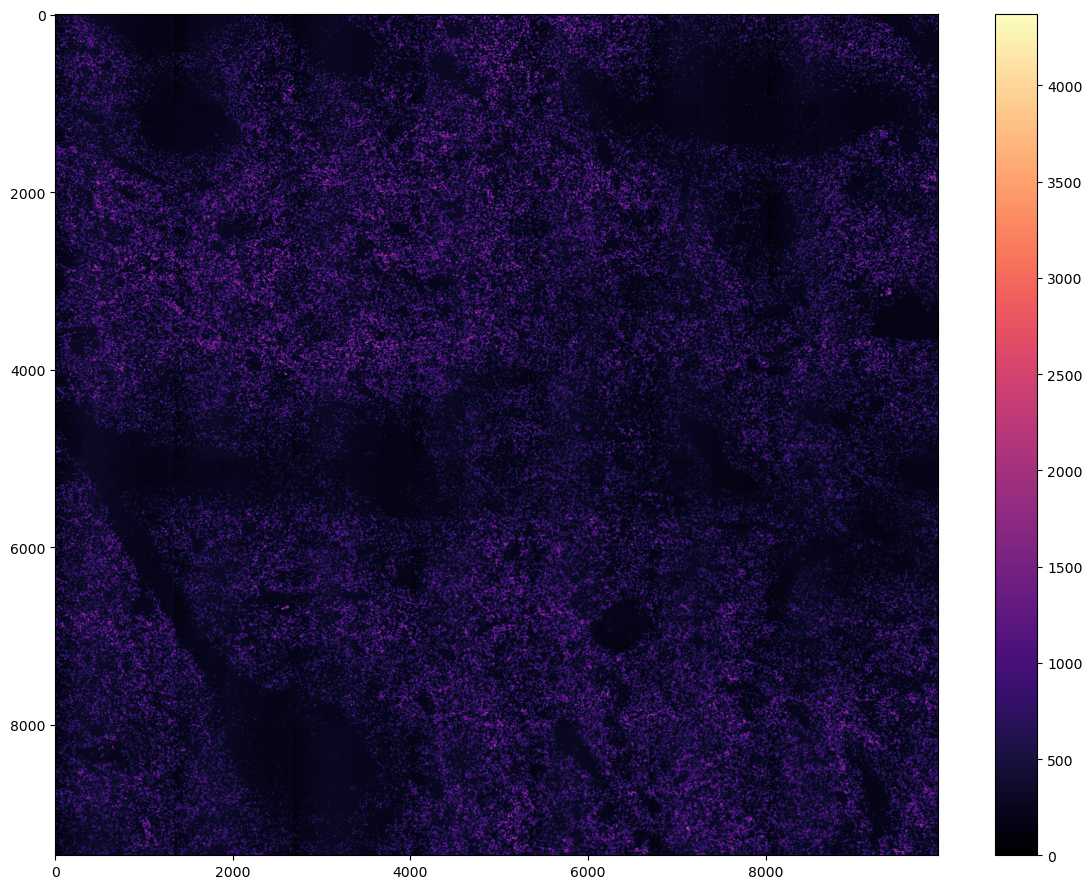

In [8]:
fig, axes = plt.subplots(figsize=(12, 9))
im = axes.imshow(stitched_image, cmap='magma')
# x1 = 1810
# x2 = 2050
# y1 = 1330
# y2 = 1650
# im = axes.imshow(stitched_image[y1:y2,x1:x2], vmax=None)
fig.colorbar(im)
fig.tight_layout()

Save the stitched image if desired.

In [ ]:
raw_image_file_path = os.path.join(meta_dir, "test_original.tif") 
imsave(raw_image_file_path, stitched_image)

Reuse the stitching model to stitch the corrected tiles.

In [15]:
result_df=pd.read_pickle(stitch_model)
result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = corrected.shape[1]
size_x = corrected.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image_basic = np.zeros_like(corrected, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image_basic[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = corrected[i]

Visualize the result of stitching the corrected tiles.  Comment/uncomment the coordinates to crop.

In [ ]:
fig, axes = plt.subplots(figsize=(12, 9))
# x1 = 6000
# x2 = 8000
# y1 = 0000
# y2 = 3000
# im = axes.imshow(stitched_image_basic[y1:y2,x1:x2])
im = axes.imshow(stitched_image_basic, cmap='magma')
fig.colorbar(im)
fig.tight_layout()

Save the corrected stitched image if desired.

In [ ]:
# stitched_image_basic_re = exposure.rescale_intensity(stitched_image_basic, in_range=(np.min(stitched_image_basic), np.max(stitched_image_basic)), out_range=(0, 65535)).astype(np.uint16)
result_image_file_path = os.path.join(meta_dir, "test_corrected.tif") 
imsave(result_image_file_path, stitched_image_basic, check_contrast=False)

Before testing deconvolution, you must correct and stitch an entire z-stack.  For this you can run the cells above for each image in the stack, or use the notebook for batch processing: 2_Cycle_Processing.ipynb

## 5. Deconvolution

The following cell has multiple parameters related to the microscope used to aquire the images and the images themselves.  Once these are input, the testing is primarily to tune the number of iterations/stop_crit necessary to get good results.  The damping and hist_clip further can improve results.  There is no need to supply a point-spread function.  Finally, finding the optimal use of computing resources on GPU or CPU is accomplished via the max_GPU and max_CPU parameters.  There is no limit to image size.  If the images are too large to fit in the specified memory maximums, the will be split into blocks and processed sequentially.

Be sure the MATLAB Runtime v9.5 (R2018, 64-bit) is installed.  Download for free here: http://www.mathworks.com/products/compiler/mcr/index.html. Reboot your computer after install.  

The image_dir and stitch_dir definitions used previously will be again used here, and a new folder will be created to save the deconvolved images.  

The original deconvolution program was for lightsheet images and modified to use with widefield fluorescence.  See https://www.nature.com/articles/s41598-019-53875-y 

Output will be written to the terminal.  Check that the first image stack is processed without error.  If there is an "Maximum variable size allowed on the device is exceeded." error, then restart the kernel, decrease the max_GPU or max_CPU parameter, rerun the decon function cell, and try again.

In [6]:
dec_cycles = 1
dec_channels = 1

# pixel size in xy dimension (nanometers)
xy_vox = 377
# pixel size in z dimension (nanometers)
z_vox = 1500
# Number of iterations of Lucy-Richardson algo before stopping unless stop_crit is met first
iterations = 25
# Microscope objective numerical aperture
mic_NA = 0.75
# Refractive index of tissue being imaged
tissue_RI = 1.3
# Opening size in millimeters of objective aperture
slit_aper = 6.5
# Focal length in millimeters of objective
f_cyl = 1
# Used to reduce noise.  Increase value for noisy images. (0-10)
damping = 0
# If set, the deconvolved images will be clipped by this percent for max and min values, and then scaled to full range of bit depth. (0-5)
hist_clip = 0.010
# Percent change between iterations to use as criteria to stop deconvolution.
stop_crit = 5.00
# Enter 1 to perform on GPU, 0 to use CPU
GPU = 1
# Percent maximum GPU memory to use if GPU = 1
max_GPU = 25
# Percent maximum RAM to use if GPU = 0
max_CPU = 20
if GPU == 1:
    max_block=max_GPU
elif GPU == 0:
    max_block=max_CPU
# The excitation and emission wavelength in nanometers
ex = 358
em = 461

decon_exe = os.path.join(base_dir, "LsDeconv.exe")
decon_dir = stitch_dir.replace('_BaSiC_Stitched', '_Decon')
source = os.path.join(stitch_dir, f"cyc{str(dec_cycles).zfill(2)}", f"CH{str(dec_channels)}")
dest = os.path.join(decon_dir, f"cyc{str(dec_cycles).zfill(2)}", f"CH{str(dec_channels)}")
os.makedirs(dest, exist_ok=True)

subprocess.run([decon_exe, source, str(xy_vox), str(z_vox), str(iterations), str(mic_NA), str(tissue_RI), str(ex), str(em), str(f_cyl), str(slit_aper), str(damping), str(hist_clip), str(stop_crit), str(max_block), str(GPU)])
gc.collect()
try:
    os.rename(os.path.join(source, 'deconvolved'), os.path.join(dest, 'deconvolved'))
except (FileNotFoundError):
    print("Reduce max memory.")

The following cell will compare the original to the deconvolved image.

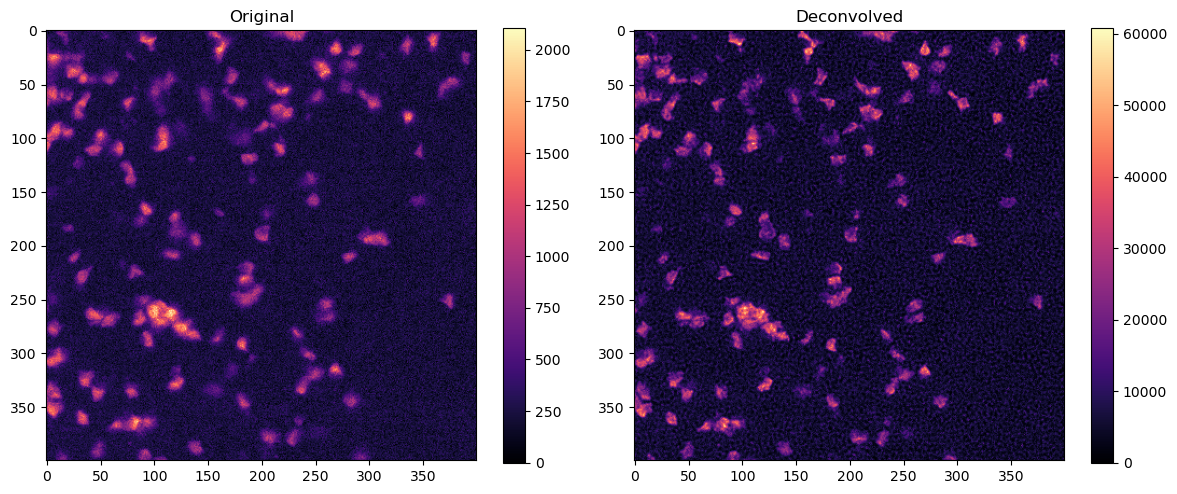

In [10]:
# Enter the cycle, channel, and z-plane for the image you want to evaluate.
c = 1
ch = 2
z = 8

# Crop the image by entering the x and y coordinates below.
x1 = 600
x2 = 1000
y1 = 800
y2 = 1200

source_image = imread(os.path.join(stitch_dir, f"cyc{str(c).zfill(2)}", f"CH{str(ch)}", f"{str(z).zfill(2)}.tif"))
dest = os.path.join(stitch_dir.replace('_BaSiC_Stitched', '_Decon'), f"cyc{str(c).zfill(2)}", f"CH{str(ch)}")
fig, axes = plt.subplots(1, 2, figsize=(12, 9))
im = axes[0].imshow(source_image[x1:x2,y1:y2], cmap='magma')
fig.colorbar(im, shrink=0.5, ax=axes[0])
axes[0].set_title("Original")
decon_image = imread(os.path.join(dest, 'deconvolved', f"deconv_0000{str(z).zfill(2)}.tif"))
im = axes[1].imshow(decon_image[x1:x2,y1:y2], cmap='magma')
fig.colorbar(im, shrink=0.5, ax=axes[1])
axes[1].set_title("Deconvolved")
fig.tight_layout()

## 6. FIJI Clij2 plugin - EDF

The following section connects this notebook with a local installation of FIJI and a Clij2 plugin to run an Extended Depth of Focus (EDF) projection along the deconvolved image stack.  The image calculation is done on the GPU for efficient processing.  In the next cell enter the amount of memory (no more than 80% of system RAM is a good rule of thumb) to allow for the computation.  Also, enter the name of the GPU, and the parameters for the EDF calculation.  A new folder will be created for the results, and the image can be inspected in another program and in the next section.

In [7]:
channel_name_dict = {"cyc01.tif" : ["DAPI", "Blank1a", "Blank1b", "Blank1c"],
 "cyc02.tif" : ["DAPI", "CD31", "CD8", "Empty2c"],
 "cyc03.tif" : ["DAPI", "CD20", "Ki67", "CD3e"],
 "cyc04.tif" : ["DAPI", "SMActin", "Podoplanin", "CD68"],
 "cyc05.tif" : ["DAPI", "PanCK", "CD21", "CD4"],
 "cyc06.tif" : ["DAPI", "Lyve1", "CD45RO", "CD11c"],
 "cyc07.tif" : ["DAPI", "CD35", "ECAD", "CD107a"],
 "cyc08.tif" : ["DAPI", "CD34", "CD44", "HLADR"],
 "cyc09.tif" : ["DAPI", "Empty9a", "FoxP3", "CD163"],
 "cyc10.tif" : ["DAPI", "Empty10a", "CollagenIV", "Vimentin"],
 "cyc11.tif" : ["DAPI", "Empty11a", "CD15", "CD45"],
 "cyc12.tif" : ["DAPI", "Empty12a", "CD5", "CD1c"],
 "cyc13.tif" : ["DAPI", "Blank13a", "Blank13b", "Blank13c"]}

In [ ]:
edf_cycles = 1
edf_channels = 2

ij_mem = 40
GPU_name = "NVIDIA RTX A4500"
fiji_dir = "C:/Users/smith6jt/Fiji.app"
javahome = 'C:/Users/smith6jt/KINTSUGI/jdk-21_windows-x64_bin/jdk-21.0.5/bin'
os.environ['PATH'] = javahome + os.pathsep + os.environ['PATH']

radius_x = 5.0
radius_y = 5.0
sigma = 20.0

scyjava.config.add_option(f'-Xmx{str(ij_mem)}g')
ij = imagej.init('C:/Users/smith6jt/Fiji.app', add_legacy=False)

macro = """
#@ File in_folder
#@ String device
#@ File out_folder
#@ String file_name
#@ Integer radius_x
#@ Integer radius_y
#@ Float sigma

File.openSequence(in_folder);
run("CLIJ2 Macro Extensions", "cl_device=[" + device + "]");
Ext.CLIJ_clear();
image1 = "deconvolved";
Ext.CLIJ2_push(image1);
image2 = "extended_depth_of_focus_variance_projection";

Ext.CLIJ2_extendedDepthOfFocusVarianceProjection(image1, image2, radius_x, radius_y, sigma);
Ext.CLIJ2_pull(image2);
Ext.CLIJ2_clear()
selectImage(image1);
close();
selectImage(image2);
saveAs("Tiff", out_folder + File.separator + file_name);
close();
"""
decon_dir = stitch_dir.replace('_BaSiC_Stitched', '_Decon')
edf_dir = decon_dir.replace('_Decon', '_EDF')
edf_source = os.path.join(decon_dir, f"cyc{str(edf_cycles).zfill(2)}", f"CH{str(edf_channels)}", "deconvolved")
edf_dest = os.path.join(edf_dir, f"cyc{str(edf_cycles).zfill(2)}")
file_name = channel_name_dict.get(f"cyc{str(edf_cycles).zfill(2)}.tif")[edf_channels-1]
os.makedirs(edf_dest, exist_ok=True)

args ={'in_folder': edf_source, "cl_device" : GPU_name, "out_folder" : edf_dest, "file_name" : file_name, "radius_x" : 5.0, "radius_y" : 5.0, "sigma" : 20.0}
ij.py.run_macro(macro, args)

Visualize the results with periodic z-planes.

In [ ]:
decon_stack = sorted(glob(os.path.join(edf_source, f"deconv_0000??.tif")), key=alphanumeric_key)
decon_stack = io.imread_collection(decon_stack)
decon_image = np.asarray(decon_stack)
edf_result = imread(os.path.join(edf_dest, file_name + ".tif"))

x1 = 2400
x2 = 3000
y1 = 2400
y2 = 3000

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
im = axes[0,0].imshow(decon_image[6][y1:y2, x1:x2])
axes[0,0].set_title("decon_z007")
im = axes[0,1].imshow(decon_image[7][y1:y2, x1:x2])
axes[0,1].set_title("decon_z008")
im = axes[0,2].imshow(decon_image[8][y1:y2, x1:x2])
axes[0,2].set_title("decon_z009")
im = axes[1,0].imshow(decon_image[9][y1:y2, x1:x2])
axes[1,0].set_title("decon_z010")
im = axes[1,1].imshow(decon_image[10][y1:y2, x1:x2])
axes[1,1].set_title("decon_z011")
im = axes[1,2].imshow(edf_result[y1:y2, x1:x2])
axes[1,2].set_title("EDF_var_radius_x5_radius_y5_sigma20")
fig.tight_layout()

Visualize the results as a full image.

In [ ]:
edf_result = imread(os.path.join(edf_dest, file_name + ".tif"))
fig, axes = plt.subplots(figsize=(24, 18))
im = axes.imshow(edf_result)
fig.colorbar(im)
fig.tight_layout()